## Hybrid method: Recursive feature addition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [9]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [10]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,is_intrusion
0,0.121478,113.0,0.0,2.0,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,0,0
1,0.649902,113.0,0.0,2.0,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,0,0
2,1.623129,113.0,0.0,2.0,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,0,0
3,1.681642,113.0,3.0,2.0,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,0,0
4,0.449454,113.0,0.0,2.0,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,0,0


### Train - Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion', 'attack'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 42), (35069, 42))

### Remove constant and quasi-constant features

In [12]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((140272, 42), (35069, 42))

### Remove duplicated

In [13]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40


1

In [14]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((140272, 41), (35069, 41))

### Train a ML model with all features

In [15]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.984772


### Rank features by importance

Text(0.5, 0, 'Feature')

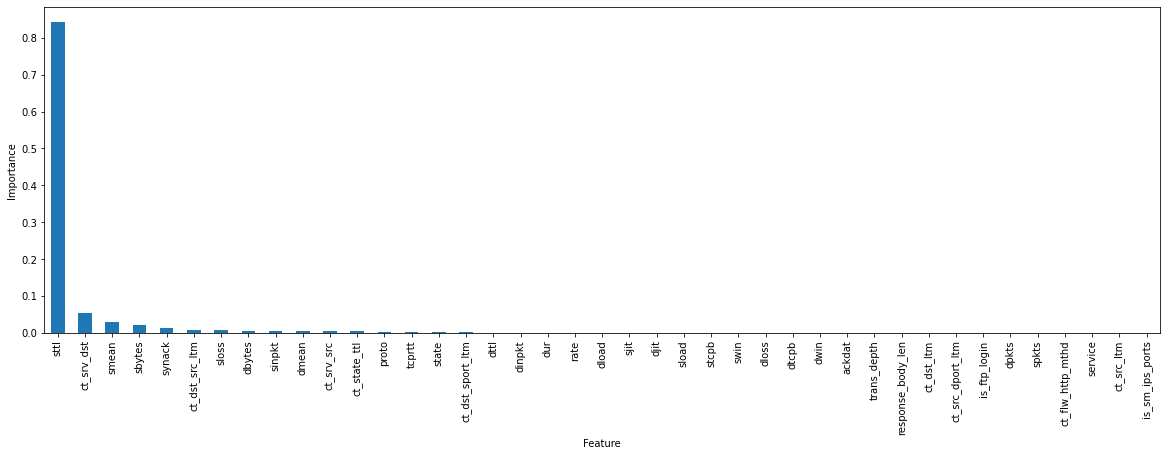

In [16]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [17]:
# make list of ordered features
features = list(features.index)
features

['sttl',
 'ct_srv_dst',
 'smean',
 'sbytes',
 'synack',
 'ct_dst_src_ltm',
 'sloss',
 'dbytes',
 'sinpkt',
 'dmean',
 'ct_srv_src',
 'ct_state_ttl',
 'proto',
 'tcprtt',
 'state',
 'ct_dst_sport_ltm',
 'dttl',
 'dinpkt',
 'dur',
 'rate',
 'dload',
 'sjit',
 'djit',
 'sload',
 'stcpb',
 'swin',
 'dloss',
 'dtcpb',
 'dwin',
 'ackdat',
 'trans_depth',
 'response_body_len',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'is_ftp_login',
 'dpkts',
 'spkts',
 'ct_flw_http_mthd',
 'service',
 'ct_src_ltm',
 'is_sm_ips_ports']

### Build a ML model with 1 feature

In [18]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# build initial model using all the features
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

Test one feature xgb ROC AUC=0.881715


### Select features

In [19]:
# first we arbitrarily set the increase in roc-auc if the increase is above this threshold,
# the feature will be kept
tol = 0.0001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with one feature
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  ct_srv_dst 1  out of  41
New Test ROC AUC=0.9358693526325206
Previous round Test ROC AUC=0.8817148819750593
Increase in ROC AUC=0.05415447065746126
keep:  ct_srv_dst

testing feature:  smean 2  out of  41
New Test ROC AUC=0.9749678345758951
Previous round Test ROC AUC=0.9358693526325206
Increase in ROC AUC=0.03909848194337451
keep:  smean

testing feature:  sbytes 3  out of  41
New Test ROC AUC=0.9827608361503065
Previous round Test ROC AUC=0.9749678345758951
Increase in ROC AUC=0.007793001574411429
keep:  sbytes

testing feature:  synack 4  out of  41
New Test ROC AUC=0.9834011567272593
Previous round Test ROC AUC=0.9827608361503065
Increase in ROC AUC=0.0006403205769527354
keep:  synack

testing feature:  ct_dst_src_ltm 5  out of  41
New Test ROC AUC=0.9836108326443235
Previous round Test ROC AUC=0.9834011567272593
Increase in ROC AUC=0.00020967591706422262
keep:  ct_dst_src_ltm

testing feature:  sloss 6  out of  41
New Test ROC AU

In [20]:
features_to_keep

['sttl',
 'ct_srv_dst',
 'smean',
 'sbytes',
 'synack',
 'ct_dst_src_ltm',
 'sloss',
 'dbytes',
 'dmean',
 'tcprtt']

In [21]:
# build initial model
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.984578


Gradient Boosting model built with 10 features shows a similar performance than the one built the full dataset.

In [22]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [23]:
X_train.shape, X_test.shape

((140272, 10), (35069, 10))

## Standardize Data





In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [25]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation





In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [27]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25).fit(X_train, y_train)

CPU times: user 76.4 ms, sys: 205 ms, total: 281 ms
Wall time: 2.33 s


In [28]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6753828167327269
F1 Score: 0.806242979201416
FPR: 1.0
TPR: 0.9942072786802669


### Naive Bayes





In [29]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-08).fit(X_train, y_train)

CPU times: user 433 ms, sys: 39.8 ms, total: 472 ms
Wall time: 60 ms


In [30]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
FPR: 1.0
TPR: 1.0


### Random Forest





In [31]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000).fit(X_train, y_train)

CPU times: user 1min 51s, sys: 717 ms, total: 1min 51s
Wall time: 1min 51s


In [32]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


### KNN




In [33]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform').fit(X_train, y_train)

CPU times: user 7.49 s, sys: 64.2 ms, total: 7.55 s
Wall time: 7.49 s


In [34]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.6793179161082438
f1: 0.8090402771174354
fpr: 1.0
tpr: 1.0


### CatBoost




In [35]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6609360	total: 64.7ms	remaining: 3.17s
1:	learn: 0.6311938	total: 74.3ms	remaining: 1.78s
2:	learn: 0.6037621	total: 83.8ms	remaining: 1.31s
3:	learn: 0.5781988	total: 93.6ms	remaining: 1.08s
4:	learn: 0.5546560	total: 103ms	remaining: 927ms
5:	learn: 0.5323825	total: 112ms	remaining: 823ms
6:	learn: 0.5117260	total: 121ms	remaining: 744ms
7:	learn: 0.4922828	total: 130ms	remaining: 684ms
8:	learn: 0.4741075	total: 141ms	remaining: 640ms
9:	learn: 0.4572260	total: 150ms	remaining: 599ms
10:	learn: 0.4412283	total: 159ms	remaining: 565ms
11:	learn: 0.4260760	total: 169ms	remaining: 535ms
12:	learn: 0.4116774	total: 178ms	remaining: 507ms
13:	learn: 0.3979396	total: 187ms	remaining: 481ms
14:	learn: 0.3852224	total: 196ms	remaining: 458ms
15:	learn: 0.3732473	total: 205ms	remaining: 436ms
16:	learn: 0.3618238	total: 215ms	remaining: 417ms
17:	learn: 0.3509360	total: 224ms	remaining: 398ms
18:	learn: 0.3407736	total: 233ms	remaining: 380ms
19:	learn: 0.3310330	total: 242ms	rem

In [36]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


## Model Evaluation





In [37]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../UNSW_Test.csv")
test_df.shape

(175341, 44)

In [38]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [39]:
X_eval = X_eval[features_to_keep]

In [40]:
X_eval.shape

(175341, 10)

### Model Evaluation - Logistic Regression





In [41]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25)
modelLR.fit(X_train, y_train)

LogisticRegression(C=25, n_jobs=-1, random_state=42)

In [42]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [43]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.867193737880689
Testing accuracy is  0.6753828167327269


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.6753828167327269
F1 Score: 0.806242979201416
Precision Score: 0.6780510148578627
Recall Score: 0.9942072786802669
Confusion Matrix:
 [[    0 11246]
 [  138 23685]]


### Cross validation - Logistic Regression





In [45]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.86824 (+/- 0.16354)
F1 Score: 0.90867 (+/- 0.09331)
Precision: 0.90767 (+/- 0.21368)
Recall: 0.92140 (+/- 0.08469)


### Model Evaluation - Naive Bayes





In [46]:
modelNB = GaussianNB(var_smoothing=1e-08)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

In [47]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [48]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.5461318010722026
Testing accuracy is  0.6793179161082438


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))



Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
Precision Score: 0.6793179161082438
Recall Score: 1.0
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Naive Bayes





In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.44793 (+/- 0.27803)
F1 Score: 0.28594 (+/- 0.51382)
Precision: 0.93373 (+/- 0.09125)
Recall: 0.20911 (+/- 0.46701)


### Model Evaluation - Random Forest




In [51]:
modelRF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=0)

In [52]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [53]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.9936124101745181
Testing accuracy is  0.6793179161082438


In [54]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Random Forest





In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92955 (+/- 0.11890)
F1 Score: 0.95116 (+/- 0.07594)
Precision: 0.94205 (+/- 0.16307)
Recall: 0.96621 (+/- 0.05464)


### Model Evaluation - KNN





In [56]:
modelKNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)

In [57]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [58]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9589155355309684
Testing accuracy is  0.6793179161082438


In [59]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.8090402771174354
Precision Score: 0.6793179161082438
Recall Score: 1.0
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - KNN




In [60]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92503 (+/- 0.11572)
F1 Score: 0.94774 (+/- 0.07322)
Precision: 0.94130 (+/- 0.16260)
Recall: 0.96016 (+/- 0.05561)


### Model Evaluation - CatBoost




In [61]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6609360	total: 9.38ms	remaining: 460ms
1:	learn: 0.6311938	total: 19.1ms	remaining: 458ms
2:	learn: 0.6037621	total: 28.6ms	remaining: 448ms
3:	learn: 0.5781988	total: 38.3ms	remaining: 441ms
4:	learn: 0.5546560	total: 47.7ms	remaining: 429ms
5:	learn: 0.5323825	total: 57.2ms	remaining: 420ms
6:	learn: 0.5117260	total: 66.7ms	remaining: 410ms
7:	learn: 0.4922828	total: 76.1ms	remaining: 400ms
8:	learn: 0.4741075	total: 87ms	remaining: 397ms
9:	learn: 0.4572260	total: 95.8ms	remaining: 383ms
10:	learn: 0.4412283	total: 106ms	remaining: 375ms
11:	learn: 0.4260760	total: 115ms	remaining: 364ms
12:	learn: 0.4116774	total: 126ms	remaining: 359ms
13:	learn: 0.3979396	total: 136ms	remaining: 349ms
14:	learn: 0.3852224	total: 146ms	remaining: 340ms
15:	learn: 0.3732473	total: 155ms	remaining: 330ms
16:	learn: 0.3618238	total: 164ms	remaining: 319ms
17:	learn: 0.3509360	total: 173ms	remaining: 308ms
18:	learn: 0.3407736	total: 182ms	remaining: 297ms
19:	learn: 0.3310330	total: 191ms

In [62]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [63]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9389685753393407
Testing accuracy is  0.6793179161082438


In [64]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - CatBoost





In [65]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6613667	total: 9.74ms	remaining: 477ms
1:	learn: 0.6320326	total: 19.7ms	remaining: 473ms
2:	learn: 0.6046291	total: 29.4ms	remaining: 461ms
3:	learn: 0.5790946	total: 41.3ms	remaining: 474ms
4:	learn: 0.5553147	total: 51ms	remaining: 459ms
5:	learn: 0.5331428	total: 62ms	remaining: 455ms
6:	learn: 0.5125526	total: 72.4ms	remaining: 445ms
7:	learn: 0.4931859	total: 82.5ms	remaining: 433ms
8:	learn: 0.4751527	total: 92.7ms	remaining: 422ms
9:	learn: 0.4581208	total: 102ms	remaining: 410ms
10:	learn: 0.4422630	total: 112ms	remaining: 399ms
11:	learn: 0.4273217	total: 123ms	remaining: 389ms
12:	learn: 0.4129718	total: 133ms	remaining: 378ms
13:	learn: 0.3992667	total: 143ms	remaining: 367ms
14:	learn: 0.3862922	total: 153ms	remaining: 358ms
15:	learn: 0.3742333	total: 163ms	remaining: 347ms
16:	learn: 0.3627981	total: 173ms	remaining: 336ms
17:	learn: 0.3521995	total: 183ms	remaining: 325ms
18:	learn: 0.3421150	total: 193ms	remaining: 314ms
19:	learn: 0.3324312	total: 202ms	re

21:	learn: 0.3162749	total: 223ms	remaining: 283ms
22:	learn: 0.3080983	total: 233ms	remaining: 274ms
23:	learn: 0.3004848	total: 244ms	remaining: 264ms
24:	learn: 0.2929304	total: 254ms	remaining: 254ms
25:	learn: 0.2858595	total: 264ms	remaining: 244ms
26:	learn: 0.2791178	total: 274ms	remaining: 234ms
27:	learn: 0.2725993	total: 284ms	remaining: 223ms
28:	learn: 0.2665731	total: 294ms	remaining: 213ms
29:	learn: 0.2605081	total: 304ms	remaining: 203ms
30:	learn: 0.2549107	total: 314ms	remaining: 192ms
31:	learn: 0.2497009	total: 323ms	remaining: 182ms
32:	learn: 0.2443803	total: 333ms	remaining: 172ms
33:	learn: 0.2395866	total: 343ms	remaining: 161ms
34:	learn: 0.2349178	total: 353ms	remaining: 151ms
35:	learn: 0.2304704	total: 362ms	remaining: 141ms
36:	learn: 0.2261157	total: 372ms	remaining: 131ms
37:	learn: 0.2218972	total: 382ms	remaining: 121ms
38:	learn: 0.2180812	total: 393ms	remaining: 111ms
39:	learn: 0.2141782	total: 402ms	remaining: 101ms
40:	learn: 0.2108654	total: 412

46:	learn: 0.1958784	total: 481ms	remaining: 30.7ms
47:	learn: 0.1932837	total: 491ms	remaining: 20.5ms
48:	learn: 0.1907331	total: 501ms	remaining: 10.2ms
49:	learn: 0.1885473	total: 511ms	remaining: 0us
0:	learn: 0.6605812	total: 9.21ms	remaining: 451ms
1:	learn: 0.6298487	total: 18.9ms	remaining: 453ms
2:	learn: 0.6012707	total: 28.6ms	remaining: 448ms
3:	learn: 0.5748966	total: 38.2ms	remaining: 439ms
4:	learn: 0.5505274	total: 47.9ms	remaining: 431ms
5:	learn: 0.5278903	total: 57.6ms	remaining: 422ms
6:	learn: 0.5062976	total: 67.4ms	remaining: 414ms
7:	learn: 0.4862171	total: 77.1ms	remaining: 405ms
8:	learn: 0.4676239	total: 87ms	remaining: 396ms
9:	learn: 0.4499846	total: 97.8ms	remaining: 391ms
10:	learn: 0.4331716	total: 108ms	remaining: 384ms
11:	learn: 0.4176026	total: 118ms	remaining: 375ms
12:	learn: 0.4032038	total: 128ms	remaining: 365ms
13:	learn: 0.3893952	total: 138ms	remaining: 356ms
14:	learn: 0.3761146	total: 148ms	remaining: 346ms
15:	learn: 0.3636341	total: 159m

19:	learn: 0.3324312	total: 206ms	remaining: 309ms
20:	learn: 0.3233607	total: 217ms	remaining: 300ms
21:	learn: 0.3144632	total: 230ms	remaining: 293ms
22:	learn: 0.3062695	total: 241ms	remaining: 283ms
23:	learn: 0.2984377	total: 252ms	remaining: 273ms
24:	learn: 0.2908355	total: 263ms	remaining: 263ms
25:	learn: 0.2837209	total: 274ms	remaining: 253ms
26:	learn: 0.2767782	total: 285ms	remaining: 243ms
27:	learn: 0.2701518	total: 298ms	remaining: 234ms
28:	learn: 0.2638772	total: 309ms	remaining: 224ms
29:	learn: 0.2579264	total: 322ms	remaining: 215ms
30:	learn: 0.2522774	total: 333ms	remaining: 204ms
31:	learn: 0.2468139	total: 343ms	remaining: 193ms
32:	learn: 0.2416084	total: 354ms	remaining: 182ms
33:	learn: 0.2366670	total: 365ms	remaining: 172ms
34:	learn: 0.2320522	total: 376ms	remaining: 161ms
35:	learn: 0.2276288	total: 387ms	remaining: 150ms
36:	learn: 0.2232667	total: 398ms	remaining: 140ms
37:	learn: 0.2192857	total: 410ms	remaining: 129ms
38:	learn: 0.2151865	total: 421

38:	learn: 0.2180812	total: 410ms	remaining: 116ms
39:	learn: 0.2141782	total: 421ms	remaining: 105ms
40:	learn: 0.2108654	total: 432ms	remaining: 94.9ms
41:	learn: 0.2073890	total: 443ms	remaining: 84.4ms
42:	learn: 0.2040310	total: 454ms	remaining: 73.9ms
43:	learn: 0.2007532	total: 465ms	remaining: 63.4ms
44:	learn: 0.1978167	total: 475ms	remaining: 52.8ms
45:	learn: 0.1948879	total: 486ms	remaining: 42.3ms
46:	learn: 0.1922084	total: 497ms	remaining: 31.7ms
47:	learn: 0.1894801	total: 509ms	remaining: 21.2ms
48:	learn: 0.1872019	total: 520ms	remaining: 10.6ms
49:	learn: 0.1849010	total: 531ms	remaining: 0us
0:	learn: 0.6616909	total: 10.3ms	remaining: 506ms
1:	learn: 0.6323463	total: 20.7ms	remaining: 496ms
2:	learn: 0.6050811	total: 30.1ms	remaining: 472ms
3:	learn: 0.5796647	total: 40.2ms	remaining: 463ms
4:	learn: 0.5561663	total: 50ms	remaining: 450ms
5:	learn: 0.5342743	total: 60ms	remaining: 440ms
6:	learn: 0.5138266	total: 70.6ms	remaining: 434ms
7:	learn: 0.4945184	total: 8

0:	learn: 0.6605812	total: 10.2ms	remaining: 501ms
1:	learn: 0.6298487	total: 23.8ms	remaining: 571ms
2:	learn: 0.6012707	total: 33.9ms	remaining: 531ms
3:	learn: 0.5748966	total: 43.5ms	remaining: 500ms
4:	learn: 0.5505274	total: 53.4ms	remaining: 481ms
5:	learn: 0.5278903	total: 63.4ms	remaining: 465ms
6:	learn: 0.5062976	total: 73.5ms	remaining: 452ms
7:	learn: 0.4862171	total: 83.8ms	remaining: 440ms
8:	learn: 0.4676239	total: 94.2ms	remaining: 429ms
9:	learn: 0.4499846	total: 104ms	remaining: 417ms
10:	learn: 0.4331716	total: 115ms	remaining: 407ms
11:	learn: 0.4176026	total: 125ms	remaining: 396ms
12:	learn: 0.4032038	total: 136ms	remaining: 386ms
13:	learn: 0.3893952	total: 147ms	remaining: 378ms
14:	learn: 0.3761146	total: 157ms	remaining: 367ms
15:	learn: 0.3636341	total: 168ms	remaining: 358ms
16:	learn: 0.3517759	total: 179ms	remaining: 347ms
17:	learn: 0.3405537	total: 190ms	remaining: 337ms
18:	learn: 0.3300214	total: 200ms	remaining: 327ms
19:	learn: 0.3198805	total: 212m

18:	learn: 0.3421150	total: 207ms	remaining: 338ms
19:	learn: 0.3324312	total: 218ms	remaining: 326ms
20:	learn: 0.3233607	total: 228ms	remaining: 315ms
21:	learn: 0.3144632	total: 239ms	remaining: 305ms
22:	learn: 0.3062695	total: 250ms	remaining: 293ms
23:	learn: 0.2984377	total: 260ms	remaining: 282ms
24:	learn: 0.2908355	total: 271ms	remaining: 271ms
25:	learn: 0.2837209	total: 281ms	remaining: 259ms
26:	learn: 0.2767782	total: 291ms	remaining: 248ms
27:	learn: 0.2701518	total: 301ms	remaining: 237ms
28:	learn: 0.2638772	total: 311ms	remaining: 225ms
29:	learn: 0.2579264	total: 321ms	remaining: 214ms
30:	learn: 0.2522774	total: 331ms	remaining: 203ms
31:	learn: 0.2468139	total: 342ms	remaining: 192ms
32:	learn: 0.2416084	total: 352ms	remaining: 181ms
33:	learn: 0.2366670	total: 362ms	remaining: 170ms
34:	learn: 0.2320522	total: 372ms	remaining: 160ms
35:	learn: 0.2276288	total: 383ms	remaining: 149ms
36:	learn: 0.2232667	total: 393ms	remaining: 138ms
37:	learn: 0.2192857	total: 407

37:	learn: 0.2218972	total: 405ms	remaining: 128ms
38:	learn: 0.2180812	total: 417ms	remaining: 118ms
39:	learn: 0.2141782	total: 428ms	remaining: 107ms
40:	learn: 0.2108654	total: 439ms	remaining: 96.4ms
41:	learn: 0.2073890	total: 451ms	remaining: 85.9ms
42:	learn: 0.2040310	total: 462ms	remaining: 75.2ms
43:	learn: 0.2007532	total: 473ms	remaining: 64.5ms
44:	learn: 0.1978167	total: 484ms	remaining: 53.8ms
45:	learn: 0.1948879	total: 495ms	remaining: 43ms
46:	learn: 0.1922084	total: 506ms	remaining: 32.3ms
47:	learn: 0.1894801	total: 517ms	remaining: 21.5ms
48:	learn: 0.1872019	total: 527ms	remaining: 10.8ms
49:	learn: 0.1849010	total: 537ms	remaining: 0us
0:	learn: 0.6616909	total: 10.5ms	remaining: 514ms
1:	learn: 0.6323463	total: 20.4ms	remaining: 489ms
2:	learn: 0.6050811	total: 30.1ms	remaining: 472ms
3:	learn: 0.5796647	total: 40.6ms	remaining: 467ms
4:	learn: 0.5561663	total: 50.1ms	remaining: 451ms
5:	learn: 0.5342743	total: 60.3ms	remaining: 442ms
6:	learn: 0.5138266	total:

0:	learn: 0.6605812	total: 10.1ms	remaining: 495ms
1:	learn: 0.6298487	total: 20.8ms	remaining: 498ms
2:	learn: 0.6012707	total: 31ms	remaining: 486ms
3:	learn: 0.5748966	total: 40.9ms	remaining: 470ms
4:	learn: 0.5505274	total: 51.2ms	remaining: 461ms
5:	learn: 0.5278903	total: 61.9ms	remaining: 454ms
6:	learn: 0.5062976	total: 72.5ms	remaining: 445ms
7:	learn: 0.4862171	total: 83.1ms	remaining: 436ms
8:	learn: 0.4676239	total: 93.3ms	remaining: 425ms
9:	learn: 0.4499846	total: 103ms	remaining: 413ms
10:	learn: 0.4331716	total: 114ms	remaining: 403ms
11:	learn: 0.4176026	total: 125ms	remaining: 394ms
12:	learn: 0.4032038	total: 135ms	remaining: 385ms
13:	learn: 0.3893952	total: 146ms	remaining: 376ms
14:	learn: 0.3761146	total: 157ms	remaining: 366ms
15:	learn: 0.3636341	total: 168ms	remaining: 357ms
16:	learn: 0.3517759	total: 180ms	remaining: 349ms
17:	learn: 0.3405537	total: 194ms	remaining: 344ms
18:	learn: 0.3300214	total: 204ms	remaining: 333ms
19:	learn: 0.3198805	total: 217ms	

19:	learn: 0.3324312	total: 213ms	remaining: 319ms
20:	learn: 0.3233607	total: 224ms	remaining: 309ms
21:	learn: 0.3144632	total: 235ms	remaining: 299ms
22:	learn: 0.3062695	total: 245ms	remaining: 288ms
23:	learn: 0.2984377	total: 256ms	remaining: 278ms
24:	learn: 0.2908355	total: 266ms	remaining: 266ms
25:	learn: 0.2837209	total: 277ms	remaining: 255ms
26:	learn: 0.2767782	total: 287ms	remaining: 245ms
27:	learn: 0.2701518	total: 298ms	remaining: 234ms
28:	learn: 0.2638772	total: 308ms	remaining: 223ms
29:	learn: 0.2579264	total: 318ms	remaining: 212ms
30:	learn: 0.2522774	total: 329ms	remaining: 201ms
31:	learn: 0.2468139	total: 339ms	remaining: 191ms
32:	learn: 0.2416084	total: 349ms	remaining: 180ms
33:	learn: 0.2366670	total: 360ms	remaining: 169ms
34:	learn: 0.2320522	total: 370ms	remaining: 159ms
35:	learn: 0.2276288	total: 380ms	remaining: 148ms
36:	learn: 0.2232667	total: 390ms	remaining: 137ms
37:	learn: 0.2192857	total: 401ms	remaining: 126ms
38:	learn: 0.2151865	total: 412

37:	learn: 0.2218972	total: 401ms	remaining: 127ms
38:	learn: 0.2180812	total: 413ms	remaining: 116ms
39:	learn: 0.2141782	total: 424ms	remaining: 106ms
40:	learn: 0.2108654	total: 435ms	remaining: 95.4ms
41:	learn: 0.2073890	total: 445ms	remaining: 84.8ms
42:	learn: 0.2040310	total: 456ms	remaining: 74.2ms
43:	learn: 0.2007532	total: 466ms	remaining: 63.5ms
44:	learn: 0.1978167	total: 476ms	remaining: 52.9ms
45:	learn: 0.1948879	total: 486ms	remaining: 42.3ms
46:	learn: 0.1922084	total: 496ms	remaining: 31.7ms
47:	learn: 0.1894801	total: 506ms	remaining: 21.1ms
48:	learn: 0.1872019	total: 516ms	remaining: 10.5ms
49:	learn: 0.1849010	total: 527ms	remaining: 0us
0:	learn: 0.6616909	total: 10.1ms	remaining: 497ms
1:	learn: 0.6323463	total: 19.9ms	remaining: 477ms
2:	learn: 0.6050811	total: 29.6ms	remaining: 464ms
3:	learn: 0.5796647	total: 39.5ms	remaining: 454ms
4:	learn: 0.5561663	total: 49.3ms	remaining: 443ms
5:	learn: 0.5342743	total: 59.4ms	remaining: 436ms
6:	learn: 0.5138266	tota

0:	learn: 0.6605812	total: 10.4ms	remaining: 509ms
1:	learn: 0.6298487	total: 20.6ms	remaining: 495ms
2:	learn: 0.6012707	total: 30.9ms	remaining: 484ms
3:	learn: 0.5748966	total: 41.5ms	remaining: 477ms
4:	learn: 0.5505274	total: 52.5ms	remaining: 472ms
5:	learn: 0.5278903	total: 63.7ms	remaining: 467ms
6:	learn: 0.5062976	total: 74.7ms	remaining: 459ms
7:	learn: 0.4862171	total: 85.8ms	remaining: 451ms
8:	learn: 0.4676239	total: 97.2ms	remaining: 443ms
9:	learn: 0.4499846	total: 108ms	remaining: 433ms
10:	learn: 0.4331716	total: 119ms	remaining: 423ms
11:	learn: 0.4176026	total: 130ms	remaining: 412ms
12:	learn: 0.4032038	total: 141ms	remaining: 402ms
13:	learn: 0.3893952	total: 152ms	remaining: 390ms
14:	learn: 0.3761146	total: 162ms	remaining: 378ms
15:	learn: 0.3636341	total: 174ms	remaining: 371ms
16:	learn: 0.3517759	total: 185ms	remaining: 359ms
17:	learn: 0.3405537	total: 196ms	remaining: 348ms
18:	learn: 0.3300214	total: 206ms	remaining: 336ms
19:	learn: 0.3198805	total: 217m

In [66]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.92193 (+/- 0.17102)
F1 Score: 0.94841 (+/- 0.10531)
Precision: 0.92583 (+/- 0.20300)
Recall: 0.98010 (+/- 0.03720)
